In [1]:
#import necessary packages
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

#load datafram
df = pd.read_csv("Reviews.csv")

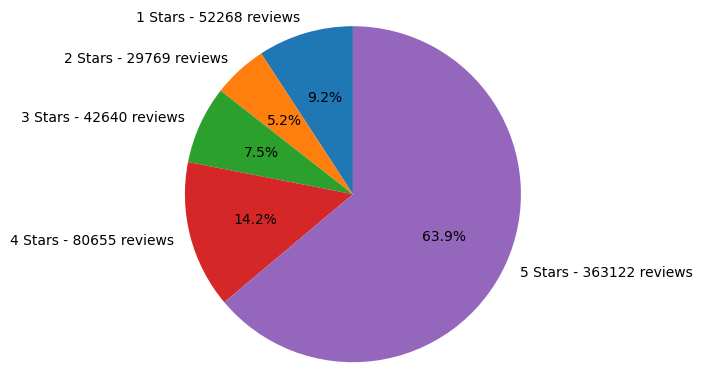

In [2]:
import matplotlib.pyplot as plt
# count of total reviews by percentages

counts = df['Score'].value_counts().sort_index()
plt.pie(counts, labels=[f"{star} Stars - {counts[star]} reviews" for star in counts.index], autopct='%1.1f%%', startangle=90)
    
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.show()

### Get the overall sentiment of the data

In [3]:
# df['sentiment'] = df['Score'].apply(lambda score: 'positive' if score > 3 else ('neutral' if score == 3 else 'negative'))
df['sentiment'] = df['Score'].apply(lambda score: 
    'very negative' if score == 1 else
    'negative' if score == 2 else
    'neutral' if score == 3 else
    'positive' if score == 4 else
    'very positive' if score == 5 else 'unknown'
)


### Preproccess the text

In [4]:
# Download NLTK stopwords and initialize the stemmer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    if isinstance(text, str) and len(text) > 0:
        text = text.lower()
        #tokenize the text
        tokens = nltk.word_tokenize(text, preserve_line=True)
        tokens = [word for word in tokens if word.isalnum()]
        #remove stop words and apply the stemmer
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
        # Join tokens back into a string
        text = ' '.join(tokens)
        
        return text
    else:
        return ""

[nltk_data] Downloading package stopwords to C:\Users\Tom
[nltk_data]     O'Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import os
from tqdm import tqdm
if os.path.exists('cleaned_dataframe.csv'):
    df = pd.read_csv('cleaned_dataframe.csv')
else:
    tqdm.pandas()
    #apply preprocessing to text
    df['cleaned_reviews'] = df['Text'].progress_apply(preprocess_text)
    df.to_csv('cleaned_dataframe.csv', index=False)


In [6]:
from sklearn.preprocessing import LabelEncoder

X = df['cleaned_reviews']
y = df['sentiment']

#split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
#turn string labels into integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
print(y_train)

[0 1 1 ... 1 1 1]


### Convert the text into numbers

In [7]:
import torch
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

### Make function to randomly sample traininig data to save gpu memory

In [8]:
import random
import numpy as np
from torch.utils.data import TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
def sample_data(X_train, y_train, sample_size=440000):
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)  
    total_samples = len(X_train)
    random_indices = np.random.choice(total_samples, sample_size, replace=False)
    X_train_sample = X_train[random_indices]
    y_train_sample = y_train[random_indices]
    X_train_sample_tfidf = tfidf_vectorizer.fit_transform(X_train_sample)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    return X_train_sample_tfidf, y_train_sample, X_test_tfidf


### Make model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
class SentimentAnalysisModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SentimentAnalysisModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x


### Make DataLoader

In [10]:
from torch.utils.data import DataLoader, TensorDataset
X_train_sample_tfidf, y_train_sample, X_test_tfidf = sample_data(X_train, y_train)
train_data = TensorDataset(torch.from_numpy(X_train_sample_tfidf.toarray()).float(), torch.from_numpy(y_train_sample))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = TensorDataset(torch.from_numpy(X_test_tfidf.toarray()).float(), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [11]:
input_size = 5000
hidden_size = 128
#Make 5 outputs for different star ratings 
output_size = 5
model = SentimentAnalysisModel(input_size, hidden_size, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Train and test the model

In [12]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device, dtype=torch.long)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += ((y_pred_class == y).sum().item()/len(y_pred))

    model.eval() 
    # Initialize the loss and accuracy
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_loader):
            # Send data to target device
            X, y = X.to(device), y.to(device, dtype=torch.long)

            # Do the testing steps
            test_pred = model(X)

            # Sum the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Sum the accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    print(f'Epoch [{epoch+1}/{num_epochs}], Train_Loss: {train_loss/len(train_loader):.4f}, Train_Acc: {train_acc/len(train_loader):.4f}, Test_Loss: {test_loss/len(test_loader):.4f}, Test_Acc: {test_acc/len(test_loader):.4f}')


Epoch [1/10], Train_Loss: 0.2965, Train_Acc: 0.8765, Test_Loss: 0.2594, Test_Acc: 0.8939
Epoch [2/10], Train_Loss: 0.2270, Train_Acc: 0.9100, Test_Loss: 0.2327, Test_Acc: 0.9078
Epoch [3/10], Train_Loss: 0.1794, Train_Acc: 0.9324, Test_Loss: 0.2266, Test_Acc: 0.9122
Epoch [4/10], Train_Loss: 0.1405, Train_Acc: 0.9492, Test_Loss: 0.2312, Test_Acc: 0.9137
Epoch [5/10], Train_Loss: 0.1058, Train_Acc: 0.9632, Test_Loss: 0.2454, Test_Acc: 0.9139
Epoch [6/10], Train_Loss: 0.0759, Train_Acc: 0.9751, Test_Loss: 0.2686, Test_Acc: 0.9133
Epoch [7/10], Train_Loss: 0.0523, Train_Acc: 0.9839, Test_Loss: 0.2970, Test_Acc: 0.9118
Epoch [8/10], Train_Loss: 0.0339, Train_Acc: 0.9905, Test_Loss: 0.3354, Test_Acc: 0.9112
Epoch [9/10], Train_Loss: 0.0218, Train_Acc: 0.9944, Test_Loss: 0.3694, Test_Acc: 0.9113
Epoch [10/10], Train_Loss: 0.0138, Train_Acc: 0.9969, Test_Loss: 0.4127, Test_Acc: 0.9109
